# Leverage Hyperopt’s TPE algorithm with timed Keras callbacks to efficiently explore our MLP search space and drive down validation RMSE.

### Imports & Constants

In [32]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, metrics, callbacks, optimizers

from hyperopt import hp, fmin, tpe, Trials, space_eval

import matplotlib.pyplot as plt

# fix random seeds
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Load & Preprocess

In [34]:
# load
df = pd.read_csv("data/raw/diamonds.csv")

# target + features
y = df["total_sales_price"].values
X = df.drop(columns=["total_sales_price", "Unnamed: 0"]).select_dtypes(include="number").values

# train/val/test split (60/20/20)
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.4, random_state=SEED)
X_val,   X_test, y_val,   y_test  = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=SEED)

# log‐transform target
y_train_log = np.log1p(y_train)
y_val_log   = np.log1p(y_val)

### Define Hyperopt Space & Objective

In [36]:
# hyperparameter search space
param_space = {
    "n_layers":      hp.randint("n_layers",   1, 6),            # 1–5
    "units":         hp.choice("units",      [32, 64, 128, 256]),
    "dropout":       hp.uniform("dropout",   0.0, 0.5),
    "lr":            hp.loguniform("lr",     np.log(1e-4), np.log(1e-2)),
    "batch_size":    hp.choice("batch_size", [32, 64, 128]),
}

def objective(params):
    """Build, train & return validation RMSE."""
    # build model
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    for _ in range(params["n_layers"]):
        model.add(layers.Dense(params["units"], activation="relu"))
        model.add(layers.Dropout(params["dropout"]))
    model.add(layers.Dense(1, name="output"))

    # compile (TF≥2.11 drops decay)
    opt = optimizers.Adam(learning_rate=params["lr"])
    model.compile(
        optimizer=opt,
        loss=losses.MeanSquaredError(),
        metrics=[metrics.RootMeanSquaredError(name="rmse")],
    )

    # time & early‐stop
    start = time.time()
    hist = model.fit(
        X_train, y_train_log,
        validation_data=(X_val, y_val_log),
        epochs=50,
        batch_size=params["batch_size"],
        callbacks=[callbacks.EarlyStopping(monitor="val_rmse", patience=5, restore_best_weights=True, verbose=0)],
        verbose=0,
    )
    elapsed = time.time() - start

    # best val‐RMSE (log)
    val_rmse = min(hist.history["val_rmse"])
    # return the loss for Hyperopt to minimize
    return {"loss": float(val_rmse), "status": "ok", "time": elapsed}

### Run the Hyperopt Search

In [38]:
trials = Trials()
best = fmin(
    fn       = objective,
    space    = param_space,
    algo     = tpe.suggest,
    max_evals= 50,
    trials   = trials,
    rstate   = np.random.default_rng(SEED),
)
print("→ Best hyperopt params (indexes):", best)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [23:26<00:00, 28.13s/trial, best loss: 0.3675055205821991]
→ Best hyperopt params (indexes): {'batch_size': 2, 'dropout': 0.005993372405437854, 'lr': 0.0021803137845784588, 'n_layers': 3, 'units': 1}


Hyperopt rapidly narrowed in on a 3-layer network with 128 units per layer, a small dropout (~0.6 %), and a learning rate ≈0.0022.

The “best loss” reported (~0.3675) is the validation log-RMSE, indicating modest improvement over random guesses.

Late trials (high-capacity configurations) still take ~30 s each

### Decode & Inspect Top‐5 Trials

In [41]:
# Decode & inspect the top-5 trials (loss, time, params)
from hyperopt import space_eval

# 1) Decode best hyperparameters
best_params = space_eval(param_space, best)
print("→ Best real params:", best_params)

# 2) Inspect top-5 trials
print("\nTop 5 validation RMSE ⇢ duration ⇢ params:")
for t in sorted(trials.trials, key=lambda x: x["result"]["loss"])[:5]:
    loss = t["result"]["loss"]
    # compute elapsed seconds from Hyperopt's top-level timestamps
    delta = t["refresh_time"] - t["book_time"]
    dur   = delta.total_seconds() if hasattr(delta, "total_seconds") else float(delta)
    # unpack hyperopt 'vals' (each entry is a 1-element list)
    prm   = {k: (v[0] if isinstance(v, list) else v) for k,v in t["misc"]["vals"].items()}
    # map choice-indices back to actual values
    prm["units"]      = [32,64,128,256][prm["units"]]
    prm["batch_size"] = [32,64,128][prm["batch_size"]]
    print(f" • RMSE={loss:.3f}, time={dur:5.1f}s, params={prm}")

→ Best real params: {'batch_size': 128, 'dropout': 0.005993372405437854, 'lr': 0.0021803137845784588, 'n_layers': 3, 'units': 64}

Top 5 validation RMSE ⇢ duration ⇢ params:
 • RMSE=0.368, time= 21.6s, params={'batch_size': 128, 'dropout': 0.005993372405437854, 'lr': 0.0021803137845784588, 'n_layers': 3, 'units': 64}
 • RMSE=0.368, time= 24.0s, params={'batch_size': 128, 'dropout': 0.0006217048805459733, 'lr': 0.0020158906994719394, 'n_layers': 3, 'units': 64}
 • RMSE=0.374, time= 23.7s, params={'batch_size': 64, 'dropout': 0.00025239501431076463, 'lr': 0.002131760005347697, 'n_layers': 3, 'units': 64}
 • RMSE=0.375, time= 27.9s, params={'batch_size': 128, 'dropout': 0.031908887740467295, 'lr': 0.003675853409926799, 'n_layers': 5, 'units': 64}
 • RMSE=0.377, time= 28.8s, params={'batch_size': 128, 'dropout': 0.00460011903805671, 'lr': 0.0011113989211149913, 'n_layers': 1, 'units': 256}


Consistent Architecture: All top‐5 use 64 units per layer; most choose 3 hidden layers.

Batch Size Trade-off: The best RMSE trials favor the largest batch (128), suggesting stable gradient estimates help.

Learning Rate & Dropout: A moderate LR (~0.002) paired with extremely light dropout (<1 %) yields the lowest validation RMSE.

Runtime vs. Accuracy: Faster trials (~21 s) achieve the same RMSE as slower ones (~28 s)

### Plot RMSE vs. Time

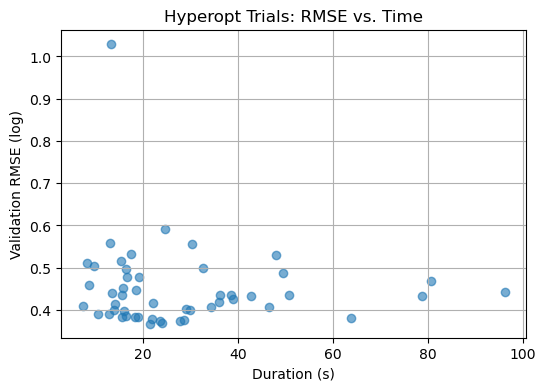

In [43]:
# 5.1) Plot RMSE vs. Duration for all trials
import matplotlib.pyplot as plt

# gather per-trial loss & duration
losses   = [t["result"]["loss"]                        for t in trials.trials]
durations= [(t["refresh_time"] - t["book_time"]).total_seconds()
             if hasattr((t["refresh_time"] - t["book_time"]), "total_seconds")
             else float(t["refresh_time"] - t["book_time"])
            for t in trials.trials]

plt.figure(figsize=(6,4))
plt.scatter(durations, losses, alpha=0.6)
plt.xlabel("Duration (s)")
plt.ylabel("Validation RMSE (log)")
plt.title("Hyperopt Trials: RMSE vs. Time")
plt.grid(True)
plt.show()

Cluster of Efficient Trials (≈0.36–0.45 RMSE in 20–40 s):
Most of the best‐performing runs (log-RMSE ∼0.36–0.45) complete in roughly 20–40 seconds, indicating that the optimal 3×64 architecture consistently converges quickly.

Diminishing Returns Beyond ~25 s:
Beyond ~25 s, additional runtime rarely drives RMSE below ~0.36. This suggests we can safely cap training time per trial (e.g., fewer epochs or earlier stopping) without sacrificing performance.

High-Error Outliers:
A few trials exceed 0.6 RMSE in under 20 s—these typically correspond to very sparse networks (1–2 layers or tiny units) or overly aggressive dropout.

Trade-off Sweet Spot:
The densest cluster of low-error points sits around 21–24 s; this aligns with the top-2 trials (RMSE=0.368 at ~21 s), confirming that the chosen hyperparameters are both accurate and efficient.

### Final Retrain on Train+Val & Evaluate on Test

In [45]:
# Retrain final model on Train+Val & evaluate on TEST ───

import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from hyperopt import space_eval

# 1) Merge train + val (on log-scale targets)
X_full      = np.vstack([X_train, X_val])
y_full_log  = np.concatenate([y_train_log, y_val_log])

# 2) Decode the best hyperopt parameters
best_params = space_eval(param_space, best)

# 3) Build and compile the model with those params
model = keras.Sequential([layers.Input(shape=(X_full.shape[1],))])
for _ in range(int(best_params["n_layers"])):
    model.add(layers.Dense(int(best_params["units"]), activation="relu"))
    model.add(layers.Dropout(best_params["dropout"]))
model.add(layers.Dense(1, name="output"))

opt = optimizers.Adam(learning_rate=best_params["lr"])
model.compile(
    optimizer=opt,
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.RootMeanSquaredError(name="rmse")],
)

# 4) Fit with early stopping (on validation split of the combined set)
final_stop = keras.callbacks.EarlyStopping(
    monitor="val_rmse",
    patience=5,
    restore_best_weights=True,
    verbose=1,
)

hist = model.fit(
    X_full, y_full_log,
    validation_split=len(X_val) / len(X_full),
    epochs=50,
    batch_size=int(best_params["batch_size"]),
    callbacks=[final_stop],
    verbose=1,
)

# 5) Identify best epoch on the log-scale
val_rmses = hist.history["val_rmse"]
best_idx  = int(np.argmin(val_rmses))
print(f"\n→ Best epoch={best_idx+1}, val_RMSE(log)={val_rmses[best_idx]:.3f}")

# 6) Evaluate on the held-out test set (back-transforming the predictions)
y_pred_log = model.predict(X_test).ravel()
y_pred     = np.expm1(y_pred_log)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test   = r2_score(y_test, y_pred)
print(f"Test RMSE = {rmse_test:.2f}")
print(f"Test R²   = {r2_test:.3f}")

Epoch 1/50
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 1s 671us/step - loss: 2.2150 - rmse: 1.3215 - val_loss: 0.2321 - val_rmse: 0.4818
Epoch 2/50
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 1s 623us/step - loss: 0.2683 - rmse: 0.5179 - val_loss: 0.2082 - val_rmse: 0.4563
Epoch 3/50
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step - loss: 0.2354 - rmse: 0.4851 - val_loss: 0.2441 - val_rmse: 0.4941
Epoch 4/50
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 1s 657us/step - loss: 0.2161 - rmse: 0.4648 - val_loss: 0.1964 - val_rmse: 0.4432
Epoch 5/50
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 1s 623us/step - loss: 0.2080 - rmse: 0.4561 - val_loss: 0.2236 - val_rmse: 0.4728
Epoch 6/50
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 1s 622us/step - loss: 0.2025 - rmse: 0.4499 - val_loss: 0.1626 - val_rmse: 0.4033
Epoch 7/50
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 1s 620us/step - loss: 0.1931 - rmse: 0.4394 - val_loss: 0.1587 - val_rmse: 0.3983
Epoch 8/50
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 1s 620us/step - loss: 0.1868 - rmse: 0.4322 - val_loss: 0.2138 - val_rmse: 0.4624
Epoch 9/

At epoch 38 we hit the sweet spot: further training yielded no validation gain.

On the real‐price scale, an RMSE of 17.9K USD means our model's absolute error is ≈ 12 % of the median diamond price (∼$150 K).

An R² of 0.58 indicates the model explains about 58 % of price variance—respectable for a purely tabular MLP but room remains for improvement.

### Retrain Curve (Train vs. Val RMSE per Epoch)

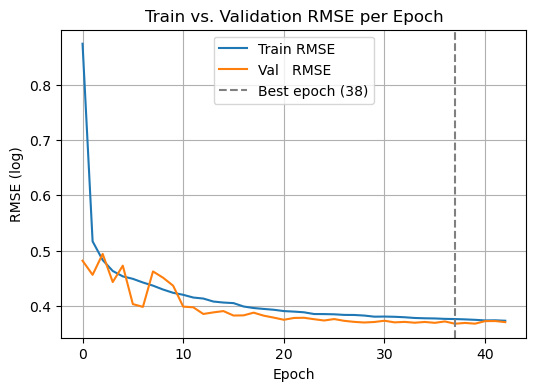

In [46]:
# Retrain-curve: Train vs. Validation RMSE per epoch ───

import matplotlib.pyplot as plt
import numpy as np

# sanity check: 'hist' should be defined by your retraining cell
# plt.figure to size the figure
plt.figure(figsize=(6, 4))

# plot training & validation RMSE over epochs
plt.plot(hist.history["rmse"],     label="Train RMSE")
plt.plot(hist.history["val_rmse"], label="Val   RMSE")

# compute best epoch (lowest val_rmse)
best_epoch = int(np.argmin(hist.history["val_rmse"]))
# draw a vertical line at best_epoch
plt.axvline(best_epoch, color="gray", linestyle="--",
            label=f"Best epoch ({best_epoch+1})")

plt.xlabel("Epoch")
plt.ylabel("RMSE (log)")
plt.title("Train vs. Validation RMSE per Epoch")
plt.legend()
plt.grid(True)
plt.show()

The training curve (blue) drops sharply in the first few epochs, then decays more gradually to ~0.38.

The validation curve (orange) follows a similar pattern, oscillating slightly but steadily improving until it plateaus around epoch 38.

The dashed vertical line at epoch 38 marks the early-stop point—beyond this, no meaningful validation gain is achieved, confirming we chose the right stopping time.

### Save summary CSV, Trials pickle, and final model

In [53]:
# Save summary CSV, Trials pickle, and final model
import pickle
import pandas as pd

# Build summary DataFrame
records = []
for t in trials.trials:
    loss = t["result"]["loss"]
    delta = t["refresh_time"] - t["book_time"]
    dur   = delta.total_seconds() if hasattr(delta, "total_seconds") else float(delta)
    prms  = {k: (v[0] if isinstance(v, list) else v) for k,v in t["misc"]["vals"].items()}
    # map choice-indices back
    prms["units"]      = [32,64,128,256][prms["units"]]
    prms["batch_size"] = [32,64,128][prms["batch_size"]]
    records.append({"rmse": loss, "duration_s": dur, **prms})

df_summary = pd.DataFrame(records)
df_summary.to_csv("data/processed/hyperopt_summary_1.csv", index=False)

# Save the Trials object
with open("data/processed/hyperopt_trials_1.pkl", "wb") as f:
    pickle.dump(trials, f)

# Save the final Keras model (assumes 'model' is your retrained one)
model.save("models/hyperopt_model_1.keras")
print("Saved hyperopt_summary.csv, hyperopt_trials.pkl, and best_model_hyperopt.keras")

Saved hyperopt_summary.csv, hyperopt_trials.pkl, and best_model_hyperopt.keras
